In [28]:
import matplotlib.pyplot as plt
import pickle as pkl

In [29]:
pkl_path = "flowstats_ra.pkl"

with open(pkl_path, "rb") as f:
    flowstats = pkl.load(f)

print(f"Loaded Ra runs: {list(flowstats.keys())}")

Loaded Ra runs: ['2500', '5000', '7500', '10000', '1000000']


In [30]:
Ra_values = []
Nu_values = []
vz_max_values = []

for ra_str, stats in flowstats.items():
    Ra_values.append(float(ra_str))

    # nusselt_step is a list or array per time step → choose mean or last
    nu_steps = stats["nusselt_step"]
    Nu_values.append(max(nu_steps))  # or mean

    vz_max_steps = stats["uz_max_step"]
    vz_max = max(vz_max_steps)  # or mean
    vz_max_values.append(vz_max)

# Sort by Ra for nice plots
Ra_values, Nu_values, vz_max_values = zip(*sorted(zip(Ra_values, Nu_values, vz_max_values)))

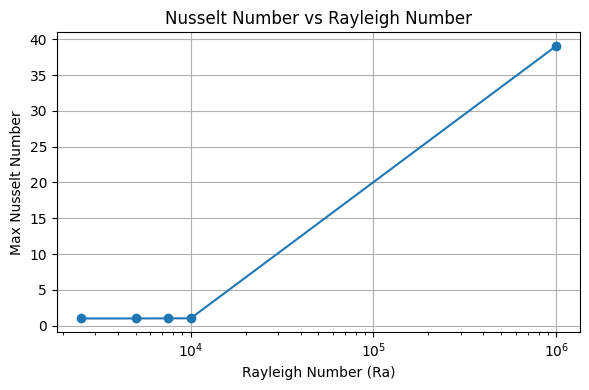

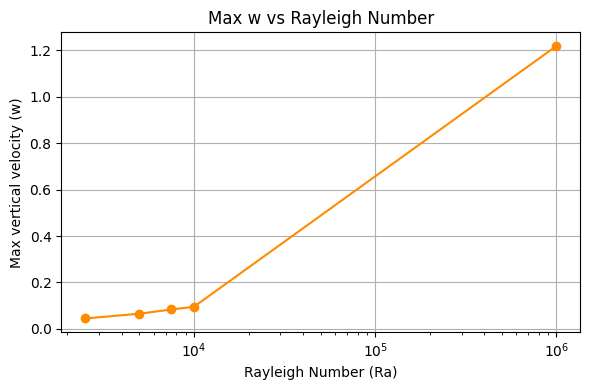

In [32]:
# ---------- Plot Nu vs Ra ----------
plt.figure(figsize=(6,4))
plt.plot(Ra_values, Nu_values, marker='o')
plt.xscale("log")
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Max Nusselt Number")
plt.title("Nusselt Number vs Rayleigh Number")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- Plot vz_max vs Ra ----------
plt.figure(figsize=(6,4))
plt.plot(Ra_values, vz_max_values, marker='o', color='darkorange')
plt.xscale("log")
plt.xlabel("Rayleigh Number (Ra)")
plt.ylabel("Max vertical velocity (w)")
plt.title("Max w vs Rayleigh Number")
plt.grid(True)
plt.tight_layout()
plt.show()